In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import wntr
from pathlib import Path
import wntr.network.controls as controls
from dreaminsg_integrated_model.src.network_sim_models.interdependencies import *
from dreaminsg_integrated_model.src.network_recovery import *
import pandapower as pp

import math
import pandapower.plotting as pandaplot

In [54]:
network_dir= 'in2'

MAIN_DIR = Path('..')
water_file = MAIN_DIR/'dreaminsg_integrated_model/data/networks/{0}/water/Example_water2.inp'.format(network_dir)

step_size = 3600
try:
    wn = wntr.network.WaterNetworkModel(water_file)
    wn.options.time.duration = 3600*24
    wn.options.time.report_timestep = step_size
    wn.options.time.hydraulic_timestep = step_size
    wn.options.hydraulic.demand_model = 'DDA'
    total_base_water_demand = sum([wn.get_node(node).base_demand for node in wn.junction_name_list])
    print(total_base_water_demand)
    print("Water network successfully loaded.")
except FileNotFoundError:
    print("Error: The water network file does not exist. No such file or directory: ", water_file)

0.06939921604
Water network successfully loaded.


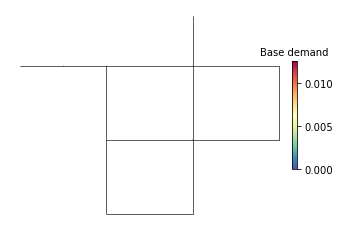

In [6]:
ax = wntr.graphics.plot_network(wn, node_attribute='base_demand',
node_colorbar_label='Base demand', node_size = 0.5, link_width = 0.5)

In [55]:

print("Simulation time: ", wn.options.time.duration,"; Hydraulic time step: ", wn.options.time.hydraulic_timestep, "; Report time step: ", wn.options.time.report_timestep)
wn_sim = wntr.sim.WNTRSimulator(wn) #wntr.sim.epanet.EpanetSimulator(wn) 
wn_results = wn_sim.run_sim()

print(wn_results.node['demand'])

Simulation time:  86400.0 ; Hydraulic time step:  3600.0 ; Report time step:  3600
       W_J10     W_J11     W_J12     W_J13     W_J21     W_J22     W_J23  \
0        0.0  0.009464  0.009464  0.006309  0.009464  0.012618  0.009464   
3600     0.0  0.009464  0.009464  0.006309  0.009464  0.012618  0.009464   
7200     0.0  0.011356  0.011356  0.007571  0.011356  0.015142  0.011356   
10800    0.0  0.011356  0.011356  0.007571  0.011356  0.015142  0.011356   
14400    0.0  0.012303  0.012303  0.008202  0.012303  0.016403  0.012303   
18000    0.0  0.012303  0.012303  0.008202  0.012303  0.016403  0.012303   
21600    0.0  0.007571  0.007571  0.005047  0.007571  0.010094  0.007571   
25200    0.0  0.007571  0.007571  0.005047  0.007571  0.010094  0.007571   
28800    0.0  0.009464  0.009464  0.006309  0.009464  0.012618  0.009464   
32400    0.0  0.009464  0.009464  0.006309  0.009464  0.012618  0.009464   
36000    0.0  0.011356  0.011356  0.007571  0.011356  0.015142  0.011356   
39600

In [9]:
wn_results.node['demand'].to_csv('results.csv')

<AxesSubplot:>

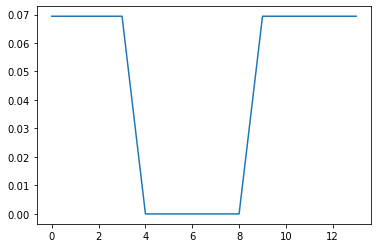

In [146]:
pd.Series(water_consump_tracker).plot()

In [79]:
t = 86400
node_results = wn_results.node['demand'].iloc[-1]

water_supplied = sum([node_results[junc] for junc in wn.junction_name_list])

base_demands_at_t = []

for junc in wn.junction_name_list:
    base_demand = wn.get_node(junc).base_demand
    
    if base_demand != 0:
        demand = node_results[junc]
        pattern = wn.get_node(junc).demand_timeseries_list[0].pattern.multipliers
        #print(pattern)
        pattern_size = len(pattern)
        pattern_interval = 24/pattern_size
        
        pattern_index = math.ceil(((t/3600)%86400) / pattern_interval)
        multiplier = pattern[pattern_index-1]
        base_demands_at_t.append(multiplier*base_demand)
        

water_resmetric = water_supplied/sum(base_demands_at_t)
print(water_resmetric)

1.0


In [62]:
wn.get_node(node).demand_timeseries_list[0].pattern.multipliers

array([1. , 1.2, 1.3, 0.8, 1. , 1.2, 1. , 1. , 1. , 1. , 1. , 1. ])